# **Data Science 100: Final Project**
---












### **Topic:** 
COVID-19 in California: Predicting Cases and Deaths

### **Team:**


*   Pranav Bhasin
*   Muskaan Goyal


# **Overview**

---










1.   <b>[About the Project](#Introduction)</b>
    *   Introduction
    *   Research Question
1.   <b>[Setup](#Setup)</b>
    *   Libraries
    *   Datasets
1.   <b>[Processing and Data Cleaning](#DataCleaning)</b>
    *   Data Cleaning
    *   Preparing Data
    *   Standardize Data
    *   Generating Training/Validation Data
1.   <b>[Prediction Model of number of cases](#Model1)</b>
    *   Window Size Tunings
    *   Threshold Tunings
    *   Lambda Tunings
1.   <b>[Prediction Model of number of deaths](#Model2)</b>
    *   Window Size Tunings
    *   Threshold Tunings
    *   Lambda Tunings
1.  <b>[Further Analysis](#FurtherAnalysis)</b>
1. <b>[Conclusion](#Conclusion)</b>
1. <b>[Resources](#Resources)</b>

# <a id='Introduction'><b>About the Project</b></a>


---





### **Introduction**

The World Health Organization (WHO) issued a “public health emergency of international concern,” on January 30th. In less than 5 months, COVID-19 has spread across the world infecting over x people, and causing nearly y deaths in over 212 countries and territories. This disease, from the class of influenza-like viruses like MERS and SARS, is a keen reminder of the Spanish Flu pandemic. 

The COVID-19 pandemic continues to have a devastating effect on the health and well-being of the global population. A critical step in the fight against COVID-19 is predicting the number of new cases and deaths. As most countries are following some form of social distancing measures, an important consideration for governments in lockdown is the growing number of cases and deaths despite these measures. This motivated our team to model the spread of the disease in the form of new cases and deaths. By leveraging time-series datasets and population, we would like to predict the 


### **Reseach Question**
* How can we predict the number of new cases of COVID-19 in 
California using the time series data of new cases in all states in the United States and their respective populations?
* How can we predict the number of deaths due COVID-19 in California using the time series data of deaths in all states in the United States and their respective populations?


# <a id='Setup'><b>Setup</b></a>

---



### **Libraries**

In [1]:
from datetime import datetime, timedelta
from dateutil import tz
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import rcParams
import warnings
import requests
from sklearn.linear_model import Ridge, Lasso
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **Datasets**

In [0]:
# Coronavirus 
confirmed_data = pd.read_csv('time_series_covid19_confirmed_US.csv')
death_data = pd.read_csv('time_series_covid19_deaths_US.csv')

In [3]:
confirmed_data.head(10)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.271000,-170.132000,"American Samoa, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.444300,144.793700,"Guam, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,3,5,12,14,15,27,29,32,37,45,51,55,56,58,69,77,82,84,93,112,113,121,121,128,130,133,133,133,133,135,135,136,136
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.097900,145.673900,"Northern Mariana Islands, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,6,6,8,8,8,8,8,11,11,11,11,11,11,11,13,13,13,14
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.220800,-66.590100,"Puerto Rico, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,5,5,5,14,21,23,31,39,51,64,79,100,127,174,239,286,316,316,452,475,513,573,620,683,725,788,897,903,923,974,1043,1068,1118
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.335800,-64.896300,"Virgin Islands, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2,2,3,3,6,6,7,17,17,17,19,22,23,30,30,30,30,37,40,42,43,43,45,45,50,51,51,51,51,51,51,51,53
5,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,6,6,6,6,6,7,8,10,12,12,12,12,12,12,15,17,19,19,19,23,24,26,26,25
6,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,1,1,2,2,2,3,4,4,5,5,10,15,18,19,20,24,28,29,29,38,42,44,56,59,66,71,72,87,91,101,103,109
7,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,3,3,4,9,9,10,10,11,12,14,15,18
8,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3,3,4,4,4,5,7,8,9,9,11,13,16,17,17,18,22,24,26
9,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,4,5,5,5,5,5,6,9,10,10,10,10,10,11,12,12,13,14,16,17,18,20,20


In [4]:
death_data.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,"American Samoa, US",55641,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,"Guam, US",164229,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,2,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,"Northern Mariana Islands, US",55144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,"Puerto Rico, US",2933408,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,1,2,2,2,2,3,3,3,6,8,11,12,15,18,20,21,23,24,33,39,42,44,45,45,51,56,58,60
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,"Virgin Islands, US",107268,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,2,3


# <a id='DataCleaning'><b>Processing And Data Cleaning</b></a>

### **Data Cleaning and Exploratory Data Analysis**

For answering our research question, we need to focus on the state-level data. As the the data presented in the tables `confirmed_data` and `death_data` is on a county-level, we need to process our tables to get the required data.
However, before we do that, we need to address the null values, and values that don't fit our criterion of being a state. 


In [5]:
confirmed_data.isna().sum().sort_values(ascending=False).head()

Admin2     7
FIPS       4
4/18/20    0
2/16/20    0
2/7/20     0
dtype: int64

In [6]:
death_data.isna().sum().sort_values(ascending=False).head()

Admin2     7
FIPS       4
4/18/20    0
2/16/20    0
2/6/20     0
dtype: int64

In [7]:
print(confirmed_data.iso3.unique())
print(death_data.iso3.unique())

['ASM' 'GUM' 'MNP' 'PRI' 'VIR' 'USA']
['ASM' 'GUM' 'MNP' 'PRI' 'VIR' 'USA']


We noticed that in both the tables, we noticed that 7 Admin2 values and 4 FIPS values are missing. From the documentation of the datasets, we know that Admin2 and FIPS represent unique counties. 

In [8]:
confirmed_data[confirmed_data['Admin2'].isna() | confirmed_data['FIPS'].isna()]

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.271000,-170.132000,"American Samoa, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.444300,144.793700,"Guam, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,3,5,12,14,15,27,29,32,37,45,51,55,56,58,69,77,82,84,93,112,113,121,121,128,130,133,133,133,133,135,135,136,136
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.097900,145.673900,"Northern Mariana Islands, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,6,6,8,8,8,8,8,11,11,11,11,11,11,11,13,13,13,14
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.220800,-66.590100,"Puerto Rico, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,5,5,5,14,21,23,31,39,51,64,79,100,127,174,239,286,316,316,452,475,513,573,620,683,725,788,897,903,923,974,1043,1068,1118
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.335800,-64.896300,"Virgin Islands, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2,2,3,3,6,6,7,17,17,17,19,22,23,30,30,30,30,37,40,42,43,43,45,45,50,51,51,51,51,51,51,51,53
3147,84070002,US,USA,840,NaN,Dukes and Nantucket,Massachusetts,US,41.406747,-70.687635,"Dukes and Nantucket,Massachusetts,US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,3,3,4,8,8,8,8,11,12,16,16,17,17,18,17,18,21,21,21,21,21,20,21,21,23
3148,84070003,US,USA,840,NaN,Kansas City,Missouri,US,39.099700,-94.578600,"Kansas City,Missouri,US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6,12,12,13,17,21,43,64,78,94,102,100,119,128,139,139,172,172,212,234,234,249,300,300,308,329,346,351,386,401,412
3200,84088888,US,USA,840,88888.0,NaN,Diamond Princess,US,0.000000,0.000000,"Diamond Princess, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,47,47,47,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49
3252,84099999,US,USA,840,99999.0,NaN,Grand Princess,US,0.000000,0.000000,"Grand Princess, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,20,21,21,22,23,23,30,28,28,28,28,28,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103
3253,84070004,US,USA,840,NaN,Michigan Department of Corrections (MDOC),Michigan,US,0.000000,0.000000,"Michigan Department of Corrections (MDOC), Mic...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,370,429,472,472,514,550


In [9]:
death_data[death_data['Admin2'].isna() | death_data['FIPS'].isna()] 

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.271000,-170.132000,"American Samoa, US",55641,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.444300,144.793700,"Guam, US",164229,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,2,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.097900,145.673900,"Northern Mariana Islands, US",55144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.220800,-66.590100,"Puerto Rico, US",2933408,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,1,2,2,2,2,3,3,3,6,8,11,12,15,18,20,21,23,24,33,39,42,44,45,45,51,56,58,60
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.335800,-64.896300,"Virgin Islands, US",107268,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,2,3
3147,84070002,US,USA,840,NaN,Dukes and Nantucket,Massachusetts,US,41.406747,-70.687635,"Dukes and Nantucket,Massachusetts,US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1
3148,84070003,US,USA,840,NaN,Kansas City,Missouri,US,39.099700,-94.578600,"Kansas City,Missouri,US",488943,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,0,5,7,7,8,8,8,8,12,12,12,13,13
3200,84088888,US,USA,840,88888.0,NaN,Diamond Princess,US,0.000000,0.000000,"Diamond Princess, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3252,84099999,US,USA,840,99999.0,NaN,Grand Princess,US,0.000000,0.000000,"Grand Princess, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0
3253,84070004,US,USA,840,NaN,Michigan Department of Corrections (MDOC),Michigan,US,0.000000,0.000000,"Michigan Department of Corrections (MDOC), Mic...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,9,12,12,15,17


**Observations**
*   Although the counties `Dukes and Nantucket` and `Kansas City` don't have FIPS for historic reasons, they are part of their respective states, and would be combined into them.
*   We first notice that the first 5 entries are US Overseas territories. As they. As they are islands, they might not accurately represent characteristics similar to that of the mainland states. So we're removing them. 
*   The Province States titled `Diamond Princess` and `Grand Princess` are in fact cruise ships that were stranded in the seas for a long-time. As the people on board were disembarked from the ship, these people are already being counted in their respective states. So, we can safely remove them from our count.
*   The last two of the entries are of correctional facilities. On further researching these numbers, we couldn't find if these were already included in the count for Michigan. Nonetheless, as these facilities are locked and are not accessible openly by the people outside, we are excluding these numbers.



In [10]:
# Removing Rows
confirmed_data_clean = confirmed_data.drop(index=[0, 1, 2, 3, 4, 3200, 3252, 3253, 3254])
death_data_clean = death_data.drop(index=[0, 1, 2, 3, 4, 3200, 3252, 3253, 3254])

# Fill NA for Valid Values
confirmed_data_clean.fillna(value="Unassigned", inplace=True)
death_data_clean.fillna(value="Unassigned", inplace=True)

confirmed_data_clean.head(5)
death_data_clean.head(5)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
5,84001001,US,USA,840,1001,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",55869,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,2,2
6,84001003,US,USA,840,1003,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",223234,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2
7,84001005,US,USA,840,1005,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",24686,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,84001007,US,USA,840,1007,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",22394,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,84001009,US,USA,840,1009,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",57826,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### **Preparing Data**

In [11]:
confirmed_data_clean = confirmed_data_clean.drop(columns = ["UID",
                                                            "iso2",
                                                            "iso3",
                                                            "code3",
                                                            "FIPS",
                                                            "Admin2",
                                                            "Country_Region",
                                                            "Lat",
                                                            "Long_",
                                                            "Combined_Key"]
                                                 ).rename(columns = {"Province_State" : "State"}
                                                          ).groupby("State").sum()
confirmed_data_clean.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
State,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,5,7,11,29,39,51,78,106,131,157,196,242,381,517,587,694,825,899,987,1060,1233,1495,1614,1765,1952,2169,2328,2703,2947,3217,3563,3734,3953,4075,4345,4571,4712
Alaska,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,3,5,8,11,13,18,30,34,41,56,58,85,102,114,119,132,143,157,171,185,190,213,226,235,246,257,272,277,285,293,300,309,314
Arizona,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,6,9,9,9,12,12,18,20,27,45,68,104,152,235,326,401,508,665,773,919,1157,1289,1530,1715,1937,2187,2486,2732,2870,3036,3018,3112,3393,3542,3705,3809,3964,4237,4511,4724
Arkansas,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,9,12,3,3,3,4,62,100,122,165,192,219,280,335,381,409,426,473,523,584,643,704,743,837,875,946,1000,1119,1171,1228,1280,1410,1498,1569,1620,1695,1744
California,0,0,0,0,2,2,2,2,2,3,3,3,6,6,6,6,6,6,6,6,7,7,8,8,8,8,8,8,8,8,10,10,10,10,10,10,11,11,12,12,...,144,178,221,281,372,373,557,700,828,1005,1243,1405,1646,2108,2538,2998,3899,4657,5095,5852,7138,8210,9399,10773,12004,12837,15034,16019,17351,18897,19710,21081,21706,22795,23931,25356,26686,27677,29157,30491


In [12]:
death_data_clean = death_data_clean.drop(columns = ["UID",
                                                            "iso2",
                                                            "iso3",
                                                            "code3",
                                                            "FIPS",
                                                            "Admin2",
                                                            "Country_Region",
                                                            "Lat",
                                                            "Long_",
                                                            "Combined_Key"]
                                                 ).rename(columns = {"Province_State" : "State"}
                                                          ).groupby("State").sum()
death_data_clean.head()

,Population,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
State,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Alabama,4903185,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,4,4,10,10,23,27,32,38,44,45,49,64,66,70,80,92,93,99,114,118,133,148,153
Alaska,731545,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,2,3,3,3,3,3,5,6,6,6,7,7,7,8,8,8,9,9,9,9,9
Arizona,7278717,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,2,2,5,6,8,13,15,17,20,24,29,32,41,52,64,65,73,80,89,97,108,115,122,131,142,150,169,180
Arkansas,3017804,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,3,5,6,7,8,10,12,12,14,16,16,18,18,21,21,25,27,29,32,33,37,37,38
California,39512223,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,4,4,4,3,5,7,12,16,18,24,25,30,39,50,65,81,94,110,124,146,173,199,238,265,289,348,380,432,495,544,583,604,640,714,767,860,956,1037,1140


Finally, we would like to ensure that our data from both tables matches up with one another.
We can run a quick smoke test by:

In [13]:
assert np.all([state in death_data_clean.index for state in confirmed_data_clean.index]), "A state in one of the tables doesn't match with the other"
print("Dataframes are matched")

Dataframes are matched


In [0]:
# Separating death_data_clean into two tables for separating populations
population = death_data_clean['Population'].to_frame()
death_data_clean.drop(columns=['Population'], inplace=True)



In [15]:
population.head()

,Population
State,
Alabama,4903185
Alaska,731545
Arizona,7278717
Arkansas,3017804
California,39512223


In [0]:
def heatmap(df, title):
    fig, ax = plt.subplots(figsize=(12,7))

    plt.title(title, fontsize= 18)
    ttl = ax.title
    ttl.set_position([0.5, 1.05])

    cmap = sns.cm.rocket_r
    sns.heatmap(df.loc[["New York", "New Jersey", "California","Texas"]],cmap=cmap,vmin=10, linewidths=0.30, ax=ax)
    plt.show()

def line_plot(df, title):
    fig, ax = plt.subplots(figsize=(12,7))

    plt.title(title, fontsize= 18)
    ttl = ax.title
    ttl.set_position([0.5, 1.05])

    plt.plot(np.arange(1,88,1), df)
    plt.plot()
    plt.show()

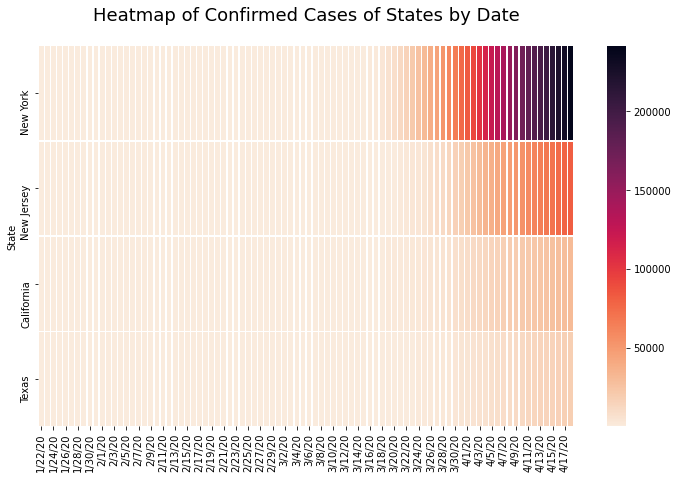

In [17]:
heatmap(confirmed_data_clean, "Heatmap of Confirmed Cases of States by Date")

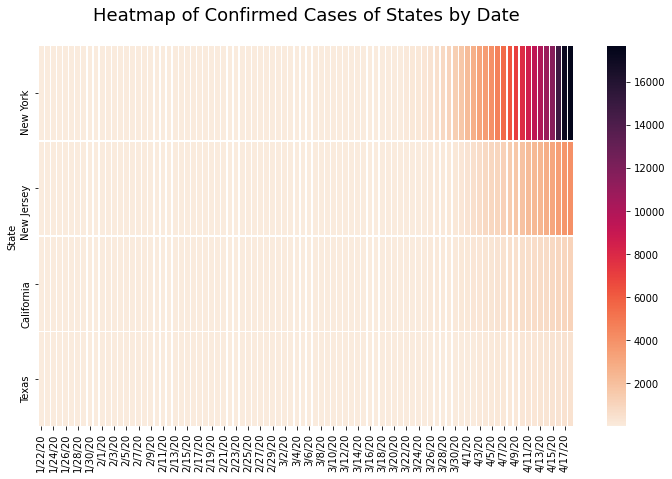

In [18]:
heatmap(death_data_clean, "Heatmap of Confirmed Cases of States by Date")

While epidemics often grow in an exponential fashion, from the heatmap we can see how the values in the different states was extremely low initially, and grew significantly toward the end supporting our notion. To account for the same in our linear model, we will linearize out data by normalization.

### **Normalize Data**

After cleaning and preparing our data, we will normalize the data. We will first divide all the entries in both the datasets by their respective state populations to help us represent the number of cases and deaths on the same scale. 

In [0]:

def normalize(data, divisor):
    return data/float(divisor)

def rev_normalize(data, multiplier):
    return data * float(multiplier)

def log_normalize(data, base=np.e):
    return np.log(np.clip(data, 1e-15, 1)) / np.log(base)

def exponential_normalize(data, base=np.e):
    return base ** data

def row_to_state(df, state = "California", threshold = 1, window_size=4, normalize_data=True):
    assert state in df.index, "Invalid State: {state}".format(state = state)

    window_size += 1
    data = df.loc[state]
    if not np.any(data >= threshold):
        return None
    Y = np.array(data[np.argmax(data >= threshold):])
    if len(Y) <= window_size:
        return None
    
    X = []

    for i in range(len(Y) - window_size):
        window = Y[i:i + window_size]
        X.append(window)

    if normalize_data:
        return normalize(np.array(X), population.loc[state])
    
    return np.array(X)


For our purpose, we created the function `state_to_input` that takes a dataframe from either `death_data_clean` or `confirmed_data_clean` to create an array for a given State that represents the possible set of windows of days. For example, for a window size of 4 days, we created windows of size 5 in which the fifth entry becomes the value and the four days represent features.

In [20]:
# Sample for California
row_to_state(confirmed_data_clean, normalize_data=False)[40]

array([ 59,  81,  95, 101, 144])

### **Generating Training/Validation Data**

We would now use our functions above to create our training and validation datasets. We do so by operating on the cleaned datasets for confirmed cases and deaths, and applying the methods defined above to each entry. For the same, we created the following method:

In [0]:
def get_data(df, train = [], val = [], threshold = 1, window_size = 4):
    def stack_state(data, state_data):
        if data is None:
            data = state_data
        else:
            data = np.vstack((data, state_data))
        return data      
    if (len(train)) == 0:
        train = list(set(df.index) - set(val))
    train_data, val_data = None, None

    for state in df.index:
        state_data = row_to_state(df, state, threshold = threshold, window_size=window_size)
        if state_data is None:
            continue
        if state in train:
            train_data = stack_state(train_data, state_data)
        else:
            val_data = stack_state(val_data, state_data)
    
    return train_data, val_data

In [0]:
# Generating data for predicted state being California
train_data_confirmed, val_data_confirmed = get_data(confirmed_data_clean,
                                                    train=[],
                                                    val = ["California"],
                                                    threshold=1,
                                                    window_size=4)
X_train_data_confirmed, y_train_data_confirmed = train_data_confirmed[:,:4], train_data_confirmed[:,4:]
X_val_data_confirmed, y_val_data_confirmed = val_data_confirmed[:,:4], val_data_confirmed[:,4:]

# <a id='Model1'><b>Prediction Model Of Number of Cases</b></a>

After generating our training and validation sets for both the datasets, we will create a prediction model of number of coronavirus cases in a region, In particular, we will predict the number of cases in California using the other data points we have.

In [0]:
def loss_function(df, state, prediction, y):
    pred = rev_normalize(prediction, df.loc[state])
    y = rev_normalize(y, df.loc[state])
    return np.mean(abs(pred - y))

In [24]:
model = Ridge(alpha = 0.002)
model.fit(X_train_data_confirmed, y_train_data_confirmed)
pred = model.predict(X_train_data_confirmed)
print("Training Accuracy:" , model.score(X_train_data_confirmed, y_train_data_confirmed, sample_weight=None))
print("Validation Accuracy:" , model.score(X_val_data_confirmed, y_val_data_confirmed, sample_weight=None))



Training Accuracy: 0.9374035038916655
Validation Accuracy: 0.6678813187596149


In [25]:
from sklearn.linear_model import RidgeCV
model = RidgeCV(alphas = [1, 0.1, 0.01, 0.001])
model.fit(np.vstack((X_train_data_confirmed, X_val_data_confirmed)), np.vstack((y_train_data_confirmed, y_val_data_confirmed)))
pred = model.predict(X_train_data_confirmed)
print("Training Accuracy:" , model.score(X_train_data_confirmed, y_train_data_confirmed, sample_weight=None))
print("Validation Accuracy:" , model.score(X_val_data_confirmed, y_val_data_confirmed, sample_weight=None))


Training Accuracy: 0.9752014590492125
Validation Accuracy: 0.8683850545233024


We utilised the regression models like RidgeRegression and RidgeCv from the sklearn library. We played around with the parameter alpha to get a decent training and validation accuracy. 

We realised that our model can be improved by optimising the parameters of our model - threshold value, window size and alpha value. To optimise these paramters, we will tune these parameters and find the optimised values.

In [0]:
def data_pipeline(data, state="California", threshold = 1, window_size = 15, alpha = 0.001):
    train_data_confirmed, val_data_confirmed = get_data(data,
                                                    train=[],
                                                    val = [state],
                                                    threshold=threshold,
                                                    window_size=window_size)
    X_train_data_confirmed, y_train_data_confirmed = train_data_confirmed[:,:window_size], train_data_confirmed[:,window_size:]
    X_val_data_confirmed, y_val_data_confirmed = val_data_confirmed[:,:window_size], val_data_confirmed[:,window_size:]

    model = Ridge(alpha = alpha)
    model.fit(X_train_data_confirmed, y_train_data_confirmed)
    pred = model.predict(X_train_data_confirmed)
    pred_val = model.predict(X_val_data_confirmed)
    return (loss_function(population,state, pred, y_train_data_confirmed),
            loss_function(population, state, pred_val, y_val_data_confirmed),
            model.score(X_train_data_confirmed, y_train_data_confirmed, sample_weight=None),
            model.score(X_val_data_confirmed, y_val_data_confirmed, sample_weight=None))


In [27]:
t_loss, v_loss, t_acc, v_acc = data_pipeline(confirmed_data_clean)
print("Training Loss:", t_loss)
print("Validation Loss:", v_loss)
print("Training Accuracy:" , t_acc)
print("Validation Accuracy:" , v_acc)


Training Loss: 5009.636440796798
Validation Loss: 4066.469756058784
Training Accuracy: 0.9694809735106876
Validation Accuracy: 0.7585031367444944


In [0]:
def visualize(values_tested, losses, param, xLog=False):
    plt.plot(values_tested, losses, label="Loss")
    plt.xlabel(f"Values of {param}")
    plt.ylabel(f"Loss")
    if xLog: plt.xscale("log")
    plt.title(f"Testing Different Values of {param}")
    plt.show()

### **Threshold Tuning**

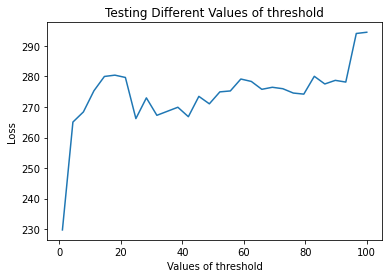

The best threshold found was 1.0 with a loss of 229.7335912124355


In [29]:
thresholds_to_test = list(np.linspace(1, 100, 30))
threshold_losses = []
for t in thresholds_to_test:
    threshold_loss = data_pipeline(confirmed_data_clean, threshold=t, alpha=0)[1]
    threshold_losses.append(threshold_loss)

best_threshold_i = np.argmin(threshold_losses)
best_threshold_cases = thresholds_to_test[best_threshold_i]
visualize(thresholds_to_test, threshold_losses, "threshold")

print(f"The best threshold found was {best_threshold_cases} with a loss of {threshold_losses[best_threshold_i]}")

### **Window size Tuning**

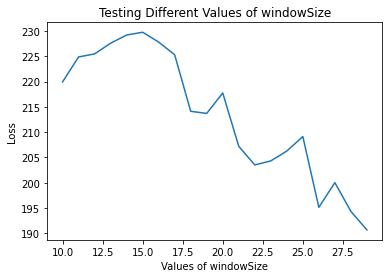

The best windowSize found was 29 with a loss of 190.69797370359373


In [30]:
windowSizes_to_test = list(range(10,30))
windowSize_losses = []
for w in windowSizes_to_test:
    windowSize_loss = data_pipeline(confirmed_data_clean, threshold=best_threshold_cases, window_size=w, alpha=0)[1]
    windowSize_losses.append(windowSize_loss)

best_windowSize_i = np.argmin(windowSize_losses)
best_windowSize_cases = windowSizes_to_test[best_windowSize_i]
visualize(windowSizes_to_test, windowSize_losses, "windowSize")

print(f"The best windowSize found was {best_windowSize_cases} with a loss of {windowSize_losses[best_windowSize_i]}")

### **Alpha Tuning**

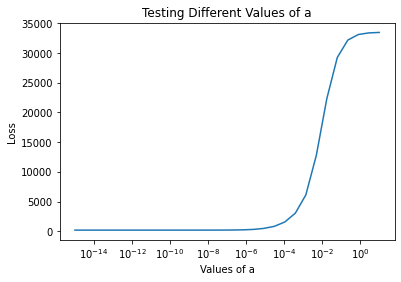

The best alpha found was 1e-15 with a loss of 190.69797460761924


In [31]:
a_to_test = list(np.geomspace(1e-15, 10, 30))
a_losses = []
for a in a_to_test:
    a_loss = data_pipeline(confirmed_data_clean, threshold=best_threshold_cases, window_size=best_windowSize_cases, alpha=a)[1]
    a_losses.append(a_loss)

best_a_i = np.argmin(a_losses)
best_a_cases = a_to_test[best_a_i]
visualize(a_to_test, a_losses, "a", True)

print(f"The best alpha found was {best_a_cases} with a loss of {a_losses[best_a_i]}")

In [32]:
t_loss_optimise, v_loss_optimise, t_acc_optimise, v_acc_optimise = data_pipeline(confirmed_data_clean, threshold=best_threshold_cases, window_size=best_windowSize_cases, alpha=best_a_i)
print("Optimised Training Loss:", t_loss_optimise)
print("Optimised Validation Loss:", v_loss_optimise)
print("Optimised Training Accuracy:" , t_acc_optimise)
print("Optimised Validation Accuracy:" , v_acc_optimise)

Optimised Training Loss: 892.7556943075328
Optimised Validation Loss: 190.69797370359373
Optimised Training Accuracy: 0.9992889331531526
Optimised Validation Accuracy: 0.9991820215919218


After tuning the parameters, we noticed that our training loss decreased from 5009 to 892, validation loss decreased from 4066 to 190, training accuracy increased from 0.96 to 0.999 and validating accuracy increased from 0.75 to 0.999.

Therefore we can say that optimising these parameters significantly improved our accuracy rates and decreased our losses in both training and validation datasets.

# <a id='Model2'><b>Prediction Model Of Number of Deaths</b></a>

We will use a similar prediction model for number of deaths in a state as the prediciton model of number of coronavirus cases in a state. Using the above workflow and optimisation, we will optimize the prediction model of the number of deaths in california. 

In [0]:
def data_pipeline(data, state="California", threshold = 1, window_size = 4, alpha = 0.00001):
    train_data_death, val_data_death = get_data(death_data_clean,
                                                    train=[],
                                                    val = [state],
                                                    threshold=threshold,
                                                    window_size=window_size)
    X_train_data_death, y_train_data_death = train_data_death[:,:window_size], train_data_death[:,window_size:]
    X_val_data_death, y_val_data_death = val_data_death[:,:window_size], val_data_death[:,window_size:]

    model = Ridge(alpha = alpha)
    model.fit(X_train_data_death, y_train_data_death)
    pred_death = model.predict(X_train_data_death)
    pred_val_death = model.predict(X_val_data_death)
    return (loss_function(population,state, pred_death, y_train_data_death),
            loss_function(population, state, pred_val_death, y_val_data_death),
            model.score(X_train_data_death, y_train_data_death, sample_weight=None),
            model.score(X_val_data_death, y_val_data_death, sample_weight=None))

In [34]:
t_loss_death, v_loss_death, t_acc_death, v_acc_death = data_pipeline(confirmed_data_clean)
print("Training Loss:", t_loss_death)
print("Validation Loss:", v_loss_death)
print("Training Accuracy:" , t_acc_death)
print("Validation Accuracy:" , v_acc_death)

Training Loss: 570.7084690161469
Validation Loss: 403.37004697067084
Training Accuracy: 0.7436291679705138
Validation Accuracy: -1.0506945802137317


### **Threshold Tuning**

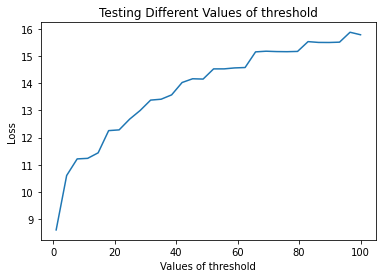

The best threshold found was 1.0 with a loss of 8.593926337671478


In [35]:
thresholds_to_test_death = list(np.linspace(1, 100, 30))
threshold_losses_death = []
for t in thresholds_to_test_death:
    threshold_loss_death = data_pipeline(death_data_clean, threshold=t, alpha=0)[1]
    threshold_losses_death.append(threshold_loss_death)

best_threshold_i_death = np.argmin(threshold_losses_death)
best_threshold_cases_death = thresholds_to_test_death[best_threshold_i_death]
visualize(thresholds_to_test_death, threshold_losses_death, "threshold")

print(f"The best threshold found was {best_threshold_cases_death} with a loss of {threshold_losses_death[best_threshold_i_death]}")

### **Window Size Tuning**

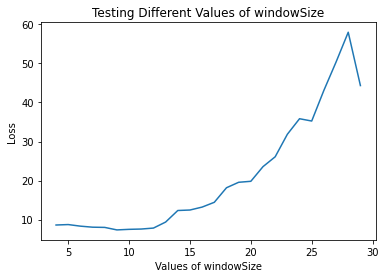

The best windowSize found was 9 with a loss of 7.335347878160615


In [36]:
windowSizes_to_test = list(range(4,30))
windowSize_losses = []
for w in windowSizes_to_test:
    windowSize_loss = data_pipeline(death_data_clean, threshold=best_threshold_cases, window_size=w, alpha=0)[1]
    windowSize_losses.append(windowSize_loss)

best_windowSize_i = np.argmin(windowSize_losses)
best_windowSize_cases = windowSizes_to_test[best_windowSize_i]
visualize(windowSizes_to_test, windowSize_losses, "windowSize")

print(f"The best windowSize found was {best_windowSize_cases} with a loss of {windowSize_losses[best_windowSize_i]}")

### **Alpha Tuning**

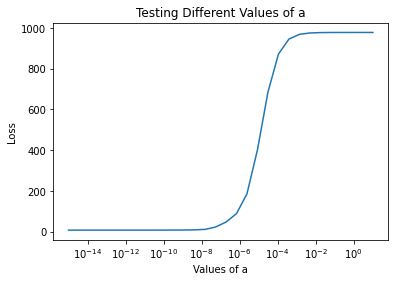

The best alpha found was 1e-15 with a loss of 7.335348588158796


In [37]:
a_to_test = list(np.geomspace(1e-15, 10, 30))
a_losses = []
for a in a_to_test:
    a_loss = data_pipeline(death_data_clean, threshold=best_threshold_cases, window_size=best_windowSize_cases, alpha=a)[1]
    a_losses.append(a_loss)

best_a_i = np.argmin(a_losses)
best_a_cases = a_to_test[best_a_i]
visualize(a_to_test, a_losses, "a", True)

print(f"The best alpha found was {best_a_cases} with a loss of {a_losses[best_a_i]}")

We have found the optimal parameters for our model. We will put them below to find the optimised training and validation loss.

In [38]:
t_loss_optimise_death, v_loss_optimise_death, t_acc_optimise_death, v_acc_optimise_death = data_pipeline(death_data_clean, threshold=best_threshold_cases, window_size=best_windowSize_cases, alpha=best_a_i)
print("Optimised Training Loss:", t_loss_optimise_death)
print("Optimised Validation Loss:", v_loss_optimise_death)
print("Optimised Training Accuracy:" , t_acc_optimise_death)
print("Optimised Validation Accuracy:" , v_acc_optimise_death)

Optimised Training Loss: 66.58197715040345
Optimised Validation Loss: 7.335347878160615
Optimised Training Accuracy: 0.9957846320582876
Optimised Validation Accuracy: 0.9984340899836208


After tuning the parameters, we noticed that our training loss decreased from 252 to 19.9, validation loss decreased from 148 to 4.2, training accuracy increased from 0.729 to 0.996 and validating accuracy increased from 0.58 to 0.998.

Therefore we can say that optimising these parameters significantly improved our accuracy rates and decreased our losses in both training and validation datasets.

# <a id='FurtherAnalysis'><b>Further Analysis</b></a>

We can further analyse the spread of coronavirus in different states as compared to the spread of coronavirus in California. 

In [0]:
def visualise_plot(states=["California"], data=confirmed_data_clean, normalizeCurves=False, title="Total Cases of COVID-19 As Fraction of Total Population", maxLabels=3, fig=1):

    if not isinstance(states, list): states = [states]
    if len(states) == 0: states = population.index
    maxStateValues = []
    midStateValues = []
        
    for i in range(len(states)):
        state = states[i]
        pop = population.loc[state][0]
        y = data.loc[state] / pop
        if normalizeCurves: 
            y /= max(y)
                
        x = list(range(len(y)))
        maxStateValues.append(max(y))
        midStateValues.append(y[35])
        plt.plot(x, y)
        plt.xlabel("Days since 1/22/20")
        plt.ylabel("Fraction of Population Infected")
        if normalizeCurves: 
            plt.ylabel("Relative Growth Curves")
    
    if len(states) < 10: 
        plt.legend(labels=states)
    else:
        if not normalizeCurves:
            topStates = states[np.array(maxStatesValues).argsort()[-maxLabels:][::-1]]
            labels = [c if c in topStates else "_"+c+"_" for c in states]
        else:
            topStates = states[np.array(midStateValues).argsort()[-maxLabels:][::-1]]
            labels = [c if c in topStates else "_"+c+"_" for c in states]          
        plt.legend(labels=labels)
    plt.title(f"Figure {fig}: {title}")
    plt.show()  

## **Visualization Plot of Fraction of People Infected**

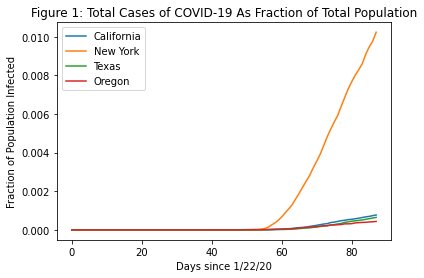

In [40]:
visualise_plot(states=['California', 'New York','Texas', 'Oregon'], fig=1)

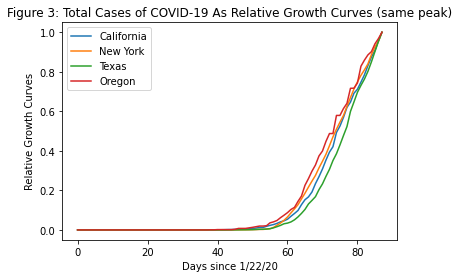

In [41]:
visualise_plot(states=['California', 'New York', 'Texas', 'Oregon'], normalizeCurves=True, title="Total Cases of COVID-19 As Relative Growth Curves (same peak)", 
           maxLabels=5, fig=3)

# <a id='Conclusion'><b>Summary of Results and Future Scope</b></a>

### **Summary of Results**
Initially we utilised the model Ridge Regression model in sklearn library which helped us train our data. We got decent training accuracy and validation accuracy, but we realised we could do better. After playing with different alpha values we decided to iterate on our model using Ridge Regression with Cross Validation model in sklearn library. Through the Ridge Regression with Cross Validation model we were able to improve our model by improving the alpha value. This iteration helped us realise that we can improve our model by improving the parameters of our model - threshold, window size and alpha value. In our final iteration, we utilised regression model and optimisation using tuning to improve our model’s training accuracy. After tuning the parameters for the number of coronavirus cases in california, we noticed that our training loss decreased from 5009 to 892, validation loss decreased from 4066 to 190, training accuracy increased from 0.96 to 0.999 and validating accuracy increased from 0.75 to 0.999. After tuning the parameters for the number of deaths in california, we noticed that our training loss decreased from 252 to 19.9, validation loss decreased from 148 to 4.2, training accuracy increased from 0.729 to 0.996 and validating accuracy increased from 0.58 to 0.998. Therefore we can say that optimising these parameters significantly improved our accuracy rates and decreased our losses in both training and validation datasets.


### **Future Scope**


*   This model currently takes only into consideration the State Population and Time Series data. This means that the model is suseptible to changes. As social distancing measure changes, this model would deviate from the initial conditions.
*   This model can be improved by considering additional features, including changes in social distancing norms.



# <a id='Resources'><b>Resources</b></a>

We utilised the following resources to build this project:

**DATASETS**

*   **time_series_covid19_deaths_US.csv:** https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv

*   **time_series_covid19_confirmed_US.csv:** https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv

*   **4.18states.csv:** https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_daily_reports_us/04-18-2020.csv

*   **abridged_couties.csv:** https://github.com/Yu-Group/covid19-severity-prediction/blob/master/data/county_data_abridged.csv: (Column Descriptions: https://github.com/Yu-Group/covid19-severity-prediction/blob/master/data/list_of_columns.md)

**DATA CLEANING AND DATA PREPARING**
* http://www.ds100.org/sp20/syllabus/


**TIME SERIES PREDICTION MODEL**
*   https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/?
*    https://elleklinton.com/covid19/

We would also like to thank our amazing professors, GSi, course staff and fellow classmates for a great semester.


